In [153]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import pprint
import sqlite3
from tqdm import tqdm
from datetime import datetime
from strategies import CustomMLStrategy
from backtest_utils import CustomCommissionSchema, CustomAnalyzer
from Share.database.downloader.downloader_base import DownloaderBase
import Share.database.database_config as db_config

In [154]:
model_pred_list = []
pred_dir = './backtest_data/'
for file_name in sorted(os.listdir(pred_dir)):
    print(file_name)
    model_pred_list.append(pd.read_pickle(pred_dir+f'{file_name}'))
model_pred_df = pd.concat(model_pred_list)
# model_pred_df = model_pred_list[-2:]
model_pred_df['stock_code'] = model_pred_df['stock_code'].map(lambda x: str(x).zfill(6))

stock_selection_results_20200101.pkl
stock_selection_results_20200701.pkl
stock_selection_results_20210101.pkl
stock_selection_results_20210701.pkl
stock_selection_results_20220101.pkl
stock_selection_results_20220701.pkl
stock_selection_results_20230101.pkl
stock_selection_results_20230701.pkl


In [155]:
BACKTEST_INITIAL_CASH = 100000  # 初始化资金
BACKTEST_INDEX_SYMBOLS = "000016"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身
# 构建数据里表
BACKTEST_STOCK_SYMBOLS = model_pred_df['stock_code'].unique().tolist()
BACKTEST_START_DATE = datetime.strptime(model_pred_df['datetime'].min(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测开始日期
BACKTEST_END_DATE = datetime.strptime(model_pred_df['datetime'].max(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测结束日期
print(f'Start: {BACKTEST_START_DATE}, End: {BACKTEST_END_DATE}')
BACKTEST_DATETIME_INDEX = pd.date_range(start=BACKTEST_START_DATE, end=BACKTEST_END_DATE, freq='B')

Start: 20200102, End: 20231222


In [156]:
# 初始化db_downloader
db_conn = sqlite3.connect("../../Share/database/hh_quant.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)

In [157]:
cerebro = bt.Cerebro()

In [158]:
print("开始设置回测基础参数...")
cerebro.broker.setcash(BACKTEST_INITIAL_CASH)  # 配置初始资金量
cerebro.broker.addcommissioninfo(CustomCommissionSchema())  # 配置自定义的佣金类型

开始设置回测基础参数...


In [159]:
print("开始添加回测股票数据...")
for stock_symbol in tqdm(BACKTEST_STOCK_SYMBOLS):
    stock_data = db_downloader._download_stock_history_info(stock_symbol, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
    if not stock_data.empty:
        stock_data = stock_data[["datetime", "open", "high", "low", "close", "volume"]]
        stock_data["datetime"] = pd.to_datetime(stock_data["datetime"])
        stock_data = stock_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='bfill').fillna(method='ffill')
        stock_data_feeds = bt.feeds.PandasData(dataname=stock_data)  # 构建回测数据Feeds流
        cerebro.adddata(stock_data_feeds, name=stock_symbol)  # 添加回测数据

开始添加回测股票数据...


100%|██████████| 50/50 [00:00<00:00, 270.96it/s]


In [160]:
print("开始添加基准数据...")
benchmark_data = db_downloader._download_index_history_info(BACKTEST_INDEX_SYMBOLS, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
benchmark_data = benchmark_data[["datetime", "open", "high", "low", "close", "volume"]]
benchmark_data["datetime"] = pd.to_datetime(benchmark_data["datetime"])
benchmark_data = benchmark_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='bfill').fillna(method='ffill')
benchmark_name = f"benchmark_{BACKTEST_INDEX_SYMBOLS}"
benchmark_data_feeds = bt.feeds.PandasData(dataname=benchmark_data)  # 构建基准数据Feeds流
cerebro.adddata(benchmark_data_feeds, name=benchmark_name)  # 添加基准数据

开始添加基准数据...


In [161]:
print("开始添加策略...")
strategy_params = {
        "top_n": 5,
        "take_profit_min_threshold": 0.0,
        "stop_loss_max_threshold": 0.0,
        "model_pred_dataframe": model_pred_df,
        "benchmark": benchmark_name,
        "risk_manage": True,
        "atr_period": 7,
        "atr_take_profit_multiplier":2 ,  # 2 * ATR作为止盈上限
        "atr_stop_loss_multiplier": 1,  # 1 * ATR作为止损下限
        "atr_risk_percent": 0.01,  # 风险0.01表示每次交易最多风险账户的1%
    }
cerebro.addstrategy(CustomMLStrategy, **strategy_params)

开始添加策略...


0

In [162]:
print("开始添加分析器...")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")  # 添加最大回撤的分析器，后续customAnalyzer中需要用到
cerebro.addanalyzer(CustomAnalyzer, _name="custom_analyzer")  # 添加自定义的分析器

开始添加分析器...


In [163]:
# print("开始添加观察器...")
# cerebro.addobserver(bt.observers.Benchmark, data=benchmark_data_feeds, timeframe=bt.TimeFrame.NoTimeFrame)  # 添加基准对比观察器

In [164]:
print("开始运行回测...")
# 运行回测
results = cerebro.run()
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

开始运行回测...
启动基准对比...
回测数据共: 50
开始计算ATR相关指标
2020-01-14 买入执行, 引用: 19454, 价格: 86.88, 成本: 16246.56, 手续费: 5.00, 数量: 187.00, 股票: 603799
2020-01-14 买入执行, 引用: 19455, 价格: 510.60, 成本: 47485.80, 手续费: 5.00, 数量: 93.00, 股票: 600436
2020-01-14 买入执行, 引用: 19456, 价格: 719.47, 成本: 15108.87, 手续费: 5.00, 数量: 21.00, 股票: 603986
2020-01-15 买入执行, 引用: 19457, 价格: 84.90, 成本: 5518.50, 手续费: 5.00, 数量: 65.00, 股票: 601899
2020-01-15 买入执行, 引用: 19458, 价格: 165.23, 成本: 3469.83, 手续费: 5.00, 数量: 21.00, 股票: 603501
2020-01-16 买入执行, 引用: 19459, 价格: 184.67, 成本: 4616.75, 手续费: 5.00, 数量: 25.00, 股票: 601888
2020-01-16 ATR 触发止损... 执行平仓【股票: 601899】, 购入价格: 84.9, 止损价格: 81.94316951270304】
2020-01-17 买入执行, 引用: 19460, 价格: 293.00, 成本: 2637.00, 手续费: 5.00, 数量: 9.00, 股票: 600809
2020-01-17 卖出执行, 引用: 19461, 价格: 81.75, 成本: 5518.50, 手续费: 5.33, 数量: -65.00, 股票: 601899
2020-01-17 买入执行, 引用: 19462, 价格: 2641.86, 成本: 2641.86, 手续费: 5.00, 数量: 1.00, 股票: 600887
2020-01-17 操作盈亏, 毛利润: -204.75, 净利润: -215.08, 股票: 601899
2020-01-17 ATR 触发止盈... 执行平仓【股票: 600436】, 购入价格: 51

开始打印回测相关指标...
Start Portfolio Value: 100000
Final Portfolio Value: 109170.57452914021
{'其他': {'亏损次数': 799,
        '夏普比率': 0.2114,
        '日均超额收益': 0.0004,
        '日胜率': 0.4691,
        '最大回撤': 24.7098,
        '最大回撤区间': 740,
        '盈亏比': 1.7391,
        '盈利次数': 497,
        '索提诺比率': 0.3181,
        '胜率': 0.3835,
        '贝塔': 0.6383,
        '超额收益': 0.3571,
        '超额收益夏普比率': 0.6885,
        '阿尔法': 0.0003},
 '基准': {'基准年化收益': -0.0722, '基准收益': -0.2654, '基准波动率': 0.1862},
 '策略': {'策略年化收益': 0.0216, '策略收益': 0.0917, '策略波动率': 0.1667}}


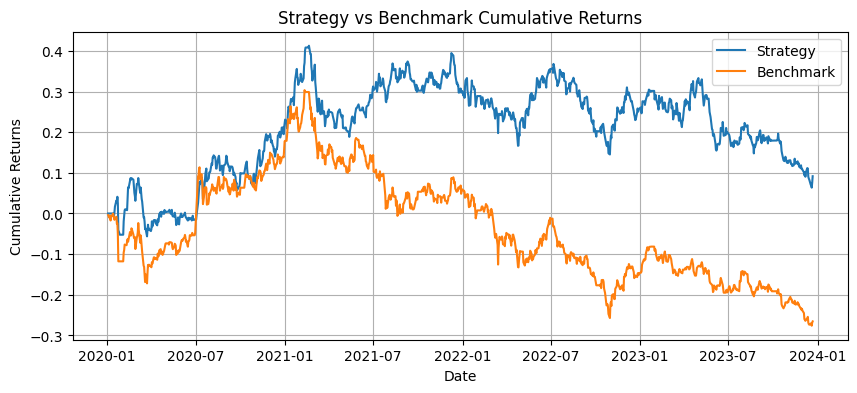

In [165]:
print("开始打印回测相关指标...")
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

def plot_strategy_benchmark_returns(strategy_returns, benchmark_returns):
    import matplotlib.pyplot as plt
    # 检查index是否一致以保证对齐
    if not strategy_returns.index.equals(benchmark_returns.index):
        raise ValueError("Indexes of strategy_returns and benchmark_returns must match")
    # 计算累积收益率
    strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1
    # 绘制累积收益率曲线
    plt.figure(figsize=(10,4))
    plt.plot(strategy_cumulative_returns, label='Strategy')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    # 添加标题和标签
    plt.title('Strategy vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    # 显示图例
    plt.legend()
    # 显示网格
    plt.grid(True)
    # 显示绘制的图形
    plt.show()

custom_analysis = results[0].analyzers.custom_analyzer.get_analysis()
format_analysis_result = {"基准": {}, "策略": {}, "其他": {}}
for key, value in custom_analysis.items():
    if key.startswith("基准"):
        format_analysis_result["基准"][key] = round(value, 4)
    elif key.startswith("策略"):
        format_analysis_result["策略"][key] = round(value, 4)
    else:
        format_analysis_result["其他"][key] = round(value, 4)
pprint.pprint(format_analysis_result)

strategy_returns = pd.Series(results[0].analyzers.custom_analyzer.get_strategy_returns(), index=benchmark_data.index[1:])
benchmark_returns = pd.Series(results[0].analyzers.custom_analyzer.get_benchmark_returns(), index=benchmark_data.index[1:])
plot_strategy_benchmark_returns(strategy_returns, benchmark_returns)

In [166]:
# %tensorboard --logdir ./logs/fit

In [167]:
annual_strategy_returns = strategy_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_benchmark_returns = benchmark_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns = pd.concat([annual_strategy_returns, annual_benchmark_returns], axis=1)
annual_returns.columns = ['Strategy', 'Benchmark']
annual_returns

,Strategy,Benchmark
2020-12-31,0.222353,0.177884
2021-12-31,0.064777,-0.100620
2022-12-31,-0.034205,-0.195176
2023-12-31,-0.131508,-0.138412
